In [5]:
%pip install pandas numpy scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pickle # Para guardar los modelos

# Cargar el dataset
# Asegúrate de subir el archivo 'loan_default_dataset.csv' a tu sesión de Colab
df = pd.read_csv('Loan_Default.csv')

# Definir las 27 columnas clave para el análisis, incluyendo la variable objetivo
COLUMNAS_CLAVE = [
    'Credit_Score', 'income', 'dtir1', 'loan_amount', 'LTV', 'property_value',
    'open_credit', 'credit_type', 'co-applicant_credit_type', 'loan_type',
    'loan_purpose', 'term', 'age', 'Gender', 'approv_in_adv',
    'business_or_commercial', 'occupancy_type', 'total_units', 'Region',
    'Secured_by', 'Security_Type', 'submission_of_application',
    'construction_type', 'loan_limit', 'Neg_ammortization',
    'interest_only', 'lump_sum_payment', 'Status' # 'Status' es la variable objetivo (Target)
]

df_trabajo = df[COLUMNAS_CLAVE].copy()

2. Comprension de los datos (EDA)

2.1. Tipos de datos 

In [7]:
print("## 2.1. Inspección Inicial")
print(df_trabajo.head())
print("-" * 50)
print(df_trabajo.info())

## 2.1. Inspección Inicial
   Credit_Score   income  dtir1  loan_amount        LTV  property_value  \
0           758   1740.0   45.0       116500  98.728814        118000.0   
1           552   4980.0    NaN       206500        NaN             NaN   
2           834   9480.0   46.0       406500  80.019685        508000.0   
3           587  11880.0   42.0       456500  69.376900        658000.0   
4           602  10440.0   39.0       696500  91.886544        758000.0   

  open_credit credit_type co-applicant_credit_type loan_type  ... Region  \
0        nopc         EXP                      CIB     type1  ...  south   
1        nopc        EQUI                      EXP     type2  ...  North   
2        nopc         EXP                      CIB     type1  ...  south   
3        nopc         EXP                      CIB     type1  ...  North   
4        nopc        CRIF                      EXP     type1  ...  North   

   Secured_by Security_Type submission_of_application constructio

2.2. Valores Nulos

In [8]:
print("\n## 2.2. Conteo y Porcentaje de Valores Nulos")
null_counts = df_trabajo.isnull().sum()
null_percentages = (null_counts / len(df_trabajo)) * 100
null_info = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
print(null_info[null_info['Count'] > 0].sort_values(by='Percentage', ascending=False))


## 2.2. Conteo y Porcentaje de Valores Nulos
                           Count  Percentage
dtir1                      24121   16.224524
LTV                        15098   10.155378
property_value             15098   10.155378
income                      9150    6.154571
loan_limit                  3344    2.249277
approv_in_adv                908    0.610749
age                          200    0.134526
submission_of_application    200    0.134526
loan_purpose                 134    0.090133
Neg_ammortization            121    0.081388
term                          41    0.027578


2.3. Análisis de la Variable Objetivo

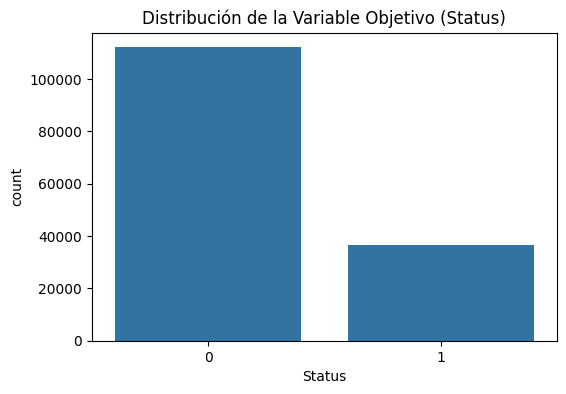


## 2.3. Proporción de Clases (Status)
Bajo Riesgo (0): 75.36%
Alto Riesgo (1): 24.64%


In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Status', data=df_trabajo)
plt.title('Distribución de la Variable Objetivo (Status)')
plt.show()

status_counts = df_trabajo['Status'].value_counts(normalize=True) * 100
print("\n## 2.3. Proporción de Clases (Status)")
print(f"Bajo Riesgo (0): {status_counts[0]:.2f}%")
print(f"Alto Riesgo (1): {status_counts[1]:.2f}%")
# Si la proporción es muy desigual (ej: 90/10), el dataset está desbalanceado.

2.4. Correlación y Distribuciones 

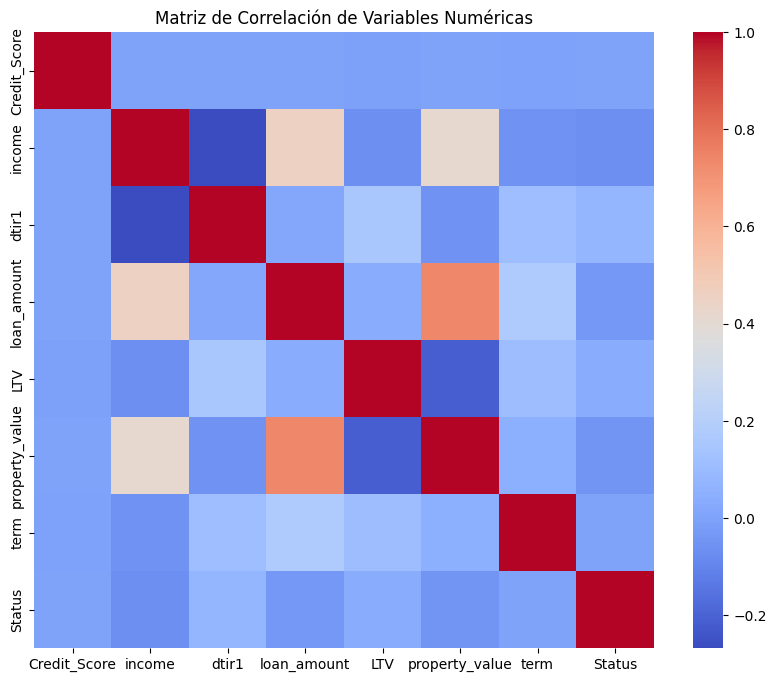

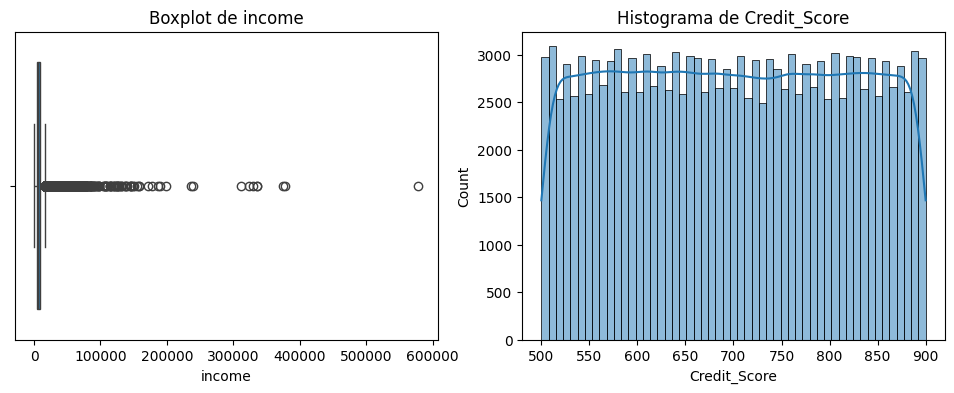

In [10]:
# Solo para variables numéricas
df_numeric = df_trabajo.select_dtypes(include=np.number)

# Matriz de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Distribuciones clave (ejemplo: Outliers)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_trabajo['income'])
plt.title('Boxplot de income')

plt.subplot(1, 2, 2)
sns.histplot(df_trabajo['Credit_Score'].dropna(), kde=True)
plt.title('Histograma de Credit_Score')
plt.show()

3. Preparacion de datos 

3.1. Division de datos

In [11]:
# Separar X e y
X = df_trabajo.drop('Status', axis=1)
y = df_trabajo['Status']

# Identificar tipos de columnas
# Asegúrate de verificar tus tipos de datos en la Fase 2.1/2.2 y ajustarlos
# 'Credit_Score' es numérico, aunque sea un score.
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# División en conjuntos de entrenamiento y prueba (Estratificado por 'Status')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

3.2. Creación del Pipeline de Preprocesamiento

In [12]:
# 1. Pipeline para variables numéricas
# Estrategia: Imputar nulos con la mediana (robusto a outliers) y luego escalar (StandardScaler)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Pipeline para variables categóricas
# Estrategia: Imputar nulos con el valor más frecuente (most_frequent) y luego codificar (One-Hot Encoding)
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' para la API
])

# 3. Combinar ambos pipelines con ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop' # Ignorar cualquier columna no especificada
)

4. Modelado y Evaluación

4.1. Pipeline del Modelo KNN

In [13]:
# 4. Pipeline Final para KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) # n_neighbors=5 es un valor inicial
])

# Entrenar el modelo
knn_pipeline.fit(X_train, y_train)

# Evaluación
y_pred_knn = knn_pipeline.predict(X_test)
y_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

print("## 4.1. Evaluación Inicial KNN")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_knn):.4f}")
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred_knn))

## 4.1. Evaluación Inicial KNN
Accuracy: 0.8568
F1-Score: 0.6295
AUC-ROC: 0.7955

Matriz de Confusión:
 [[21861   545]
 [ 3712  3616]]


4.2. Pipeline del Modelo SVM

In [14]:
# 4. Pipeline Final para SVM
# Usar SVC con un kernel 'rbf' o 'linear' (probar ambos)
LIMITE_DATOS = 10000

X_train_svm = X_train.head(LIMITE_DATOS)
y_train_svm = y_train.head(LIMITE_DATOS)

print(f"Número original de muestras de entrenamiento: {len(X_train)}")
print(f"Número de muestras de entrenamiento para SVM (reducido): {len(X_train_svm)}")
print("-" * 50)

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, random_state=42, probability=True))
])

# Entrenar el modelo
svm_pipeline.fit(X_train_svm, y_train_svm)

# Evaluación
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

print("\n## 4.2. Evaluación Inicial SVM")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_svm):.4f}")
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred_svm))

Número original de muestras de entrenamiento: 118936
Número de muestras de entrenamiento para SVM (reducido): 10000
--------------------------------------------------

## 4.2. Evaluación Inicial SVM
Accuracy: 0.8681
F1-Score: 0.6421
AUC-ROC: 0.8634

Matriz de Confusión:
 [[22294   112]
 [ 3810  3518]]


despliegue 

In [15]:
# Serializar (guardar) el Pipeline de KNN
with open('pipeline_knn.pkl', 'wb') as file:
    pickle.dump(knn_pipeline, file)

# Serializar (guardar) el Pipeline de SVM
with open('pipeline_svm.pkl', 'wb') as file:
    pickle.dump(svm_pipeline, file)

print("\n✅ Modelos serializados (pipeline_knn.pkl y pipeline_svm.pkl) listos para la API.")


✅ Modelos serializados (pipeline_knn.pkl y pipeline_svm.pkl) listos para la API.


In [16]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import pickle

print("\n--- 5.3. Iniciando GridSearchCV para SVM (Optimizado para F1) ---")

# Grid de hiperparámetros ampliado
param_grid = {
    'classifier__C': [0.1, 1, 10, 50, 100],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

#  Auto-balanceo mediante CV estratificado
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch optimizado para F1
grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',  # <---- OPTIMIZAMOS F1 DIRECTAMENTE
    cv=cv,
    verbose=2,
    n_jobs=-1
)

# Entrenamos usando tu subconjunto de 10.000 datos
grid_search_svm.fit(X_train_svm, y_train_svm) 

print("\n--- GridSearchCV finalizado ---")
print("\n✅ Mejores Parámetros (SVM):", grid_search_svm.best_params_)
print(f"✅ Mejor F1-Score (CV): {grid_search_svm.best_score_:.4f}")

# Extraemos el mejor pipeline
best_svm_pipeline = grid_search_svm.best_estimator_

# --- 5.4 Evaluación Final en Test ---
print("\n## 5.4. Evaluación Final del MEJOR SVM (Tuneado)")

y_pred_best_svm = best_svm_pipeline.predict(X_test)
y_proba_best_svm = best_svm_pipeline.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_best_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_best_svm):.4f}")

print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred_best_svm))

# Guardar modelo final
with open('best_svm_pipeline.pkl', 'wb') as file:
    pickle.dump(best_svm_pipeline, file)

print("\n✅ El mejor pipeline de SVM ha sido serializado como 'best_svm_pipeline.pkl'.")


--- 5.3. Iniciando GridSearchCV para SVM (Optimizado para F1) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

Usando muestra reducida: 11893 filas (antes 118936)

### Entrenando KNN con GridSearch ###
Fitting 3 folds for each of 6 candidates, totalling 18 fits

### Entrenando SVM con GridSearch ###
Fitting 3 folds for each of 4 candidates, totalling 12 fits

### EVALUACIÓN FINAL ###

--- Modelo: KNN ---
Mejores parámetros: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     22406
           1       0.93      0.45      0.60      7328

    accuracy                           0.86     29734
   macro avg       0.89      0.72      0.76     29734
weighted avg       0.87      0.86      0.84     29734

AUC-ROC: 0.7993


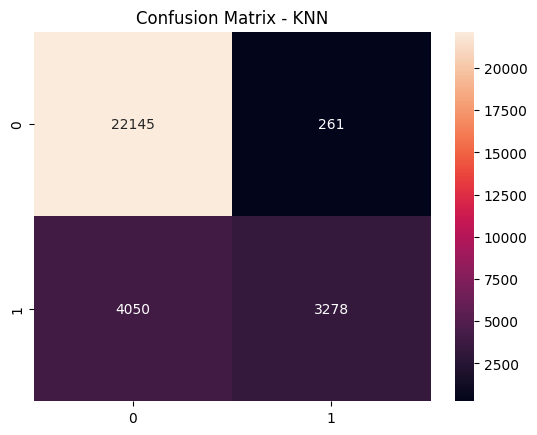


--- Modelo: SVM ---
Mejores parámetros: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     22406
           1       0.96      0.48      0.64      7328

    accuracy                           0.87     29734
   macro avg       0.91      0.74      0.78     29734
weighted avg       0.88      0.87      0.85     29734

AUC-ROC: 0.8616


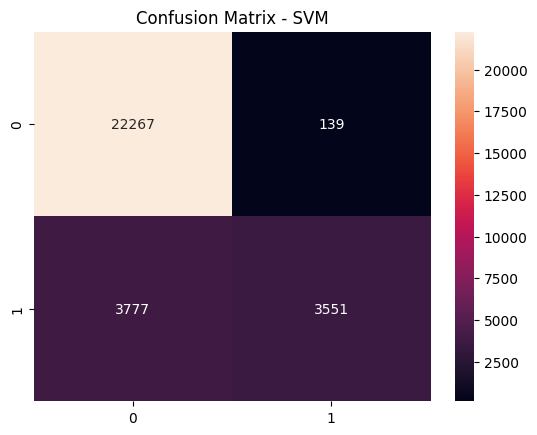


### Comparación Final de Modelos ###
     Accuracy  Recall (Default)  F1-Score (Default)   AUC-ROC
KNN  0.855014          0.447325            0.603294  0.799289
SVM  0.868299          0.484580            0.644582  0.861613

✅ Mejor modelo basado en F1-Score (Default): SVM
📦 Modelo KNN guardado como 'best_knn_model.pkl'
📦 Modelo SVM guardado como 'best_svm_model.pkl'

📦 Modelo guardado como 'best_credit_risk_model.pkl'.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import joblib

# ------------------------------------------------------------------------------------
# 0. (Debes tener cargado df, X_train, y_train, X_test, y_test y preprocessor)
# ------------------------------------------------------------------------------------
if 'df' in locals() and not df.empty:

    # -----------------------------------------------------------------------
    # 1. Crear un subconjunto reducido y estratificado (10%)
    # -----------------------------------------------------------------------
    try:
        X_sample, _, y_sample, _ = train_test_split(
            X_train, y_train,
            test_size=0.90,   # quedarse con el 10%
            random_state=42,
            stratify=y_train
        )

        print(f"Usando muestra reducida: {X_sample.shape[0]} filas (antes {X_train.shape[0]})")

    except Exception as e:
        print(f"Error en muestreo: {e} — usando dataset completo.")
        X_sample, y_sample = X_train, y_train

    # -----------------------------------------------------------------------
    # 2. Crear pipelines de modelos
    # -----------------------------------------------------------------------
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])

    # -----------------------------------------------------------------------
    # 3. GridSearch para KNN y SVM (usando la muestra)
    # -----------------------------------------------------------------------
    param_grid_knn = {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__weights': ['uniform', 'distance']
    }

    param_grid_svm = {
        'classifier__C': [0.1, 1],
        'classifier__kernel': ['linear', 'rbf']
    }

    print("\n### Entrenando KNN con GridSearch ###")
    grid_search_knn = GridSearchCV(
        knn_pipeline, param_grid_knn,
        cv=3, scoring='f1_weighted',
        n_jobs=-1, verbose=1
    )
    grid_search_knn.fit(X_sample, y_sample)
    best_knn = grid_search_knn.best_estimator_

    print("\n### Entrenando SVM con GridSearch ###")
    grid_search_svm = GridSearchCV(
        svm_pipeline, param_grid_svm,
        cv=3, scoring='f1_weighted',
        n_jobs=-1, verbose=1
    )
    grid_search_svm.fit(X_sample, y_sample)
    best_svm = grid_search_svm.best_estimator_

    # -----------------------------------------------------------------------
    # 4. Evaluación final en el set de prueba COMPLETO
    # -----------------------------------------------------------------------
    models = {
        'KNN': best_knn,
        'SVM': best_svm
    }

    results = {}

    print("\n### EVALUACIÓN FINAL ###")

    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        auc_score = roc_auc_score(y_test, y_proba)

        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Recall (Default)': report['1']['recall'],
            'F1-Score (Default)': report['1']['f1-score'],
            'AUC-ROC': auc_score
        }

        print(f"\n--- Modelo: {name} ---")
        print("Mejores parámetros:", model.named_steps['classifier'].get_params())
        print(classification_report(y_test, y_pred))
        print(f"AUC-ROC: {auc_score:.4f}")

        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    # -----------------------------------------------------------------------
    # 5. Comparación entre KNN vs SVM
    # -----------------------------------------------------------------------
    results_df = pd.DataFrame(results).T
    print("\n### Comparación Final de Modelos ###")
    print(results_df)

    best_model_name = results_df['F1-Score (Default)'].idxmax()
    best_model = models[best_model_name]

    print(f"\n✅ Mejor modelo basado en F1-Score (Default): {best_model_name}")

    # -----------------------------------------------------------------------
    # 6. Guardar el mejor modelo para producción
    # -----------------------------------------------------------------------
    joblib.dump(best_knn, 'best_knn_model.pkl')
    print("📦 Modelo KNN guardado como 'best_knn_model.pkl'")

    joblib.dump(best_svm, 'best_svm_model.pkl')
    print("📦 Modelo SVM guardado como 'best_svm_model.pkl'")

    joblib.dump(best_model, 'best_credit_risk_model.pkl')
    print("\n📦 Modelo guardado como 'best_credit_risk_model.pkl'.")
